# Energy Allocation

# Load data and packages

In [1]:
using XLSX, Gurobi, StatsBase, CSV, DataFrames, 
JuMP, LinearAlgebra, Distributions, Random,
GLMNet, ScikitLearn, MLBase, CategoricalArrays, Plots,
Dates, Clustering, Distances, StatsPlots, ProgressMeter, 
StableRNGs, ParallelKMeans

In [2]:
# Read xlsm file
initial_df = DataFrame(XLSX.readtable("eCO2mix_RTE_Annuel-Definitif_2020.xlsm", "eCO2mix_RTE_Annuel-Definitif_20"));

# Let's clean the data

# Remove all rows with missing values
df = dropmissing(initial_df, disallowmissing=true);

# remove every columns before the Date column and after the Ech. comm. Allemagne-Belgique column
df = df[:, 3:23]

# put the columns PrÈvision J-1, PrÈvision J, Pompage, Ech. physiques
prev_pomp_df = df[:, [4, 5, 13, 15]]
# drom column 4,5,13,15
df = df[:, Not([4, 5, 13, 15])]

# rename the columns
rename!(df, Symbol.(["Date", "Time", "Consumption", "Fuel", "Coal", "Gas", "Nuclear", "Wind", "Solar", "Hydraulic", "Bioenergy", "CO2", "England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]))

# for each country, we will divide in import and export, depending on the sign of the corresponding column

neighbors_columns = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]
for col in neighbors_columns
    # create a new import column, which values are positive if the original column is positive, and 0 otherwise
    df[!, Symbol(col * "_import")] = max.(df[!, Symbol(col)], 0)
    # create a new export column, which values are positive if the original column is negative, and 0 otherwise
    df[!, Symbol(col * "_export")] = max.(-df[!, Symbol(col)], 0)
end

# drop the original columns
df = df[:, Not(neighbors_columns)]


# convert the date column to a string
df[!, :Date] = string.(df[!, :Date])
# convert the time column to a string
df[!, :Time] = string.(df[!, :Time])
# merge the date and time columns into a single column
df[!, :DateTime] = df[!, :Date] .* " " .* df[!, :Time]
# convert the DateTime column to a DateTime type
df[!, :DateTime] = DateTime.(df[!, :DateTime], "yyyy-mm-dd HH:MM:SS")
# convert date and time columns to a DateTime type
df[!, :Date] = Date.(df[!, :Date], "yyyy-mm-dd")
df[!, :Time] = Time.(df[!, :Time], "HH:MM:SS")

# sort the dataframe by DateTime
df = sort(df, :DateTime)
# put the DateTime column as the first column
df = df[:, [end; 1:end-1]]

# transform everything into float
df[!, :Consumption] = convert(Array{Float64}, df[!, :Consumption])
df[!, :Fuel] = convert(Array{Float64}, df[!, :Fuel])
df[!, :Coal] = convert(Array{Float64}, df[!, :Coal])
df[!, :Gas] = convert(Array{Float64}, df[!, :Gas])
df[!, :Nuclear] = convert(Array{Float64}, df[!, :Nuclear])
df[!, :Wind] = convert(Array{Float64}, df[!, :Wind])
df[!, :Solar] = convert(Array{Float64}, df[!, :Solar])
df[!, :Hydraulic] = convert(Array{Float64}, df[!, :Hydraulic])
df[!, :Bioenergy] = convert(Array{Float64}, df[!, :Bioenergy])
df[!, :CO2] = convert(Array{Float64}, df[!, :CO2])
df[!, :England_import] = convert(Array{Float64}, df[!, :England_import])
df[!, :England_export] = convert(Array{Float64}, df[!, :England_export])
df[!, :Spain_import] = convert(Array{Float64}, df[!, :Spain_import])
df[!, :Spain_export] = convert(Array{Float64}, df[!, :Spain_export])
df[!, :Italy_import] = convert(Array{Float64}, df[!, :Italy_import])
df[!, :Italy_export] = convert(Array{Float64}, df[!, :Italy_export])
df[!, :Switzerland_import] = convert(Array{Float64}, df[!, :Switzerland_import])
df[!, :Switzerland_export] = convert(Array{Float64}, df[!, :Switzerland_export])
df[!, :Germany_Belgium_import] = convert(Array{Float64}, df[!, :Germany_Belgium_import])
df[!, :Germany_Belgium_export] = convert(Array{Float64}, df[!, :Germany_Belgium_export]);

In [3]:
df

Row,DateTime,Date,Time,Consumption,Fuel,Coal,Gas,Nuclear,Wind,Solar,Hydraulic,Bioenergy,CO2,England_import,England_export,Spain_import,Spain_export,Italy_import,Italy_export,Switzerland_import,Switzerland_export,Germany_Belgium_import,Germany_Belgium_export
,DateTime,Date,Time,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-01-01T00:00:00,2020-01-01,00:00:00,67068.0,300.0,14.0,6515.0,49226.0,3748.0,0.0,9084.0,1185.0,40.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0
2,2020-01-01T00:30:00,2020-01-01,00:30:00,66103.0,107.0,13.0,6692.0,49436.0,3627.0,0.0,9586.0,1194.0,39.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0
3,2020-01-01T01:00:00,2020-01-01,01:00:00,63943.0,106.0,13.0,6257.0,48970.0,3203.0,0.0,9133.0,1188.0,37.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1035.0,0.0
4,2020-01-01T01:30:00,2020-01-01,01:30:00,63904.0,107.0,14.0,5630.0,49648.0,2981.0,0.0,9124.0,1187.0,34.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1085.0,0.0
5,2020-01-01T02:00:00,2020-01-01,02:00:00,63408.0,107.0,14.0,5337.0,49764.0,2799.0,0.0,8699.0,1198.0,33.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1668.0,0.0
6,2020-01-01T02:30:00,2020-01-01,02:30:00,62711.0,107.0,15.0,4495.0,49747.0,2763.0,0.0,8212.0,1184.0,29.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1761.0,0.0
7,2020-01-01T03:00:00,2020-01-01,03:00:00,60825.0,107.0,14.0,3660.0,49527.0,2810.0,0.0,7658.0,1185.0,26.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,595.0,0.0
8,2020-01-01T03:30:00,2020-01-01,03:30:00,59332.0,107.0,14.0,2942.0,49887.0,2822.0,0.0,7335.0,1194.0,22.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,499.0,0.0
9,2020-01-01T04:00:00,2020-01-01,04:00:00,58004.0,107.0,13.0,2942.0,49299.0,2752.0,0.0,7021.0,1201.0,23.0,0.0,1704.0,1109.0,0.0,0.0,969.0,0.0,2402.0,237.0,0.0


In [4]:
function production_capacity_economical_cost(df, push_nuclear=0.2, push_solar=0.15)
    inc_nuc = 1 + push_nuclear
    inc_sol = 1 + push_solar
    
    # get max value of nuclear production overall
    max_nuclear = maximum(df[!, :Nuclear])
    df[!, :Nuclear_cap] = fill(max_nuclear* inc_nuc, size(df[!, :Nuclear]))
    max_hydraulic = maximum(df[!, :Hydraulic])
    df[!, :Hydraulic_cap] = fill(max_hydraulic* inc_nuc, size(df[!, :Hydraulic]))
    max_bioenergy = maximum(df[!, :Bioenergy])
    df[!, :Bioenergy_cap] = fill(max_bioenergy* inc_nuc, size(df[!, :Bioenergy]))


    df[!, :Week] = Dates.week.(df[!, :Date])
    # get the average production of gas, coal, fuel, solar and wind for each week of the year in one dataframe
    df_weekly = combine(groupby(df, :Week), :Solar => mean => :Solar_cap, :Wind => mean => :Wind_cap, :Gas => mean => :Gas_cap, :Coal => mean => :Coal_cap, :Fuel => mean => :Fuel_cap)
    # sort the dataframe by week
    df_weekly = sort(df_weekly, :Week)
    # add 20% to each column of df_weekly
    df_weekly[!, :Solar_cap] = df_weekly[!, :Solar_cap] * inc_sol
    df_weekly[!, :Wind_cap] = df_weekly[!, :Wind_cap] * inc_sol
    df_weekly[!, :Gas_cap] = df_weekly[!, :Gas_cap] * inc_sol
    df_weekly[!, :Coal_cap] = df_weekly[!, :Coal_cap] * inc_sol
    df_weekly[!, :Fuel_cap] = df_weekly[!, :Fuel_cap] * inc_sol
    # sort the dataframe by week
    df_weekly = sort(df_weekly, :Week)
    # merge the two dataframes df and df_weekly on week column
    df = leftjoin(df, df_weekly, on=:Week)

    cost_nuclear = 59.8:2:109.8
    cost_wind = 90:1:90
    cost_hydraulic = 15:0.5:20
    cost_solar = 142:1:142
    cost_gas = 70:2:100
    cost_coal = 100:1:100
    cost_fuel = 86:1:86
    cost_bioenergy = 85:2:122

    # create a vector of size 53 for each type of energy cost with random values in the range defined above
    cost_nuclear = rand(cost_nuclear, 53)
    # vary the costs with a random number in the std of the range of values
    cost_nuclear = cost_nuclear .+ randn(53) * std(cost_nuclear)

    cost_hydraulic = rand(cost_hydraulic, 53)
    cost_hydraulic = cost_hydraulic .+ randn(53) * std(cost_hydraulic)

    cost_gas = rand(cost_gas, 53)
    cost_gas = cost_gas .+ randn(53) * std(cost_gas)

    cost_bioenergy = rand(cost_bioenergy, 53)
    cost_bioenergy = cost_bioenergy .+ randn(53) * std(cost_bioenergy)

    cost_wind = rand(cost_wind, 53)
    cost_wind = cost_wind .+ randn(53) * std(cost_wind)

    cost_solar = rand(cost_solar, 53)
    cost_solar = cost_solar .+ randn(53) * std(cost_solar)

    cost_coal = rand(cost_coal, 53)
    cost_coal = cost_coal .+ randn(53) * std(cost_coal)

    cost_fuel = rand(cost_fuel, 53)
    cost_fuel = cost_fuel .+ randn(53) * std(cost_fuel)

    # create a dataframe with the cost of each type of energy
    df_cost = DataFrame(Week = 1:53, Nuclear_cost = cost_nuclear, Wind_cost = cost_wind, Solar_cost = cost_solar, Gas_cost = cost_gas, Coal_cost = cost_coal, Fuel_cost = cost_fuel, Hydraulic_cost = cost_hydraulic, Bioenergy_cost = cost_bioenergy)
    # sort the dataframe by week
    df_cost = sort(df_cost, :Week)

    # merge the two dataframes df and df_cost on week column
    df = leftjoin(df, df_cost, on=:Week)

    return df
end

df_transformed = production_capacity_economical_cost(df)

Row,DateTime,Date,Time,Consumption,Fuel,Coal,Gas,Nuclear,Wind,Solar,Hydraulic,Bioenergy,CO2,England_import,England_export,Spain_import,Spain_export,Italy_import,Italy_export,Switzerland_import,Switzerland_export,Germany_Belgium_import,Germany_Belgium_export,Nuclear_cap,Hydraulic_cap,Bioenergy_cap,Week,Solar_cap,Wind_cap,Gas_cap,Coal_cap,Fuel_cap,Nuclear_cost,Wind_cost,Solar_cost,Gas_cost,Coal_cost,Fuel_cost,Hydraulic_cost,Bioenergy_cost
,DateTime,Date,Time,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,2020-01-01T00:00:00,2020-01-01,00:00:00,67068.0,300.0,14.0,6515.0,49226.0,3748.0,0.0,9084.0,1185.0,40.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
2,2020-01-01T00:30:00,2020-01-01,00:30:00,66103.0,107.0,13.0,6692.0,49436.0,3627.0,0.0,9586.0,1194.0,39.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
3,2020-01-01T01:00:00,2020-01-01,01:00:00,63943.0,106.0,13.0,6257.0,48970.0,3203.0,0.0,9133.0,1188.0,37.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1035.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
4,2020-01-01T01:30:00,2020-01-01,01:30:00,63904.0,107.0,14.0,5630.0,49648.0,2981.0,0.0,9124.0,1187.0,34.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1085.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
5,2020-01-01T02:00:00,2020-01-01,02:00:00,63408.0,107.0,14.0,5337.0,49764.0,2799.0,0.0,8699.0,1198.0,33.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1668.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
6,2020-01-01T02:30:00,2020-01-01,02:30:00,62711.0,107.0,15.0,4495.0,49747.0,2763.0,0.0,8212.0,1184.0,29.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1761.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
7,2020-01-01T03:00:00,2020-01-01,03:00:00,60825.0,107.0,14.0,3660.0,49527.0,2810.0,0.0,7658.0,1185.0,26.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,595.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
8,2020-01-01T03:30:00,2020-01-01,03:30:00,59332.0,107.0,14.0,2942.0,49887.0,2822.0,0.0,7335.0,1194.0,22.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,499.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732
9,2020-01-01T04:00:00,2020-01-01,04:00:00,58004.0,107.0,13.0,2942.0,49299.0,2752.0,0.0,7021.0,1201.0,23.0,0.0,1704.0,1109.0,0.0,0.0,969.0,0.0,2402.0,237.0,0.0,65664.0,21172.8,1656.0,1,630.703,3975.33,7326.91,16.6223,125.067,46.746,90.0,142.0,75.4515,100.0,86.0,15.1676,107.732


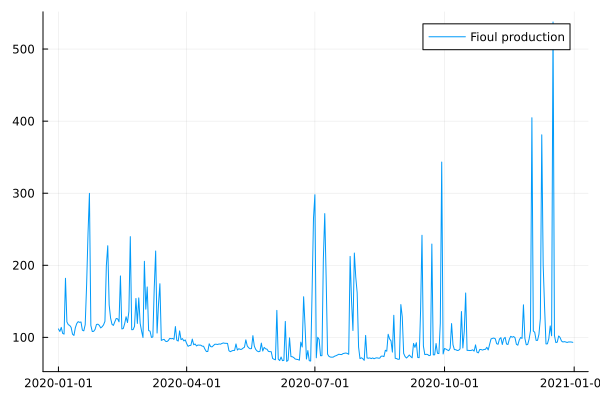

In [16]:
# create a daily average production dataframe
df_daily = combine(groupby(df, :Date), :Solar => mean => :Solar_mean, :Wind => mean => :Wind_mean, :Hydraulic => mean => :Hydraulic_mean, :Bioenergy => mean => :Bioenergy_mean, :Nuclear => mean => :Nuclear_mean, :Gas => mean => :Gas_mean, :Coal => mean => :Coal_mean, :Fuel => mean => :Fuel_mean, :Consumption => mean => :Consumption_mean)
# sort the dataframe by date
df_daily = sort(df_daily, :Date)
# plot the data
#plot(df_daily[!, :Date], df_daily[!, :Solar_mean], label="Solar production", xlabel="Date", ylabel="Solar production", title="Daily average solar production respect to the time")
#plot(df_daily[!, :Date], df_daily[!, :Wind_mean], label="Wind production")
#plot(df_daily[!, :Date], df_daily[!, :Hydraulic_mean], label="Hydraulic production")
#plot(df_daily[!, :Date], df_daily[!, :Bioenergy_mean], label="Bioenergy production")
#plot(df_daily[!, :Date], df_daily[!, :Nuclear_mean], label="Nuclear production")
#plot(df_daily[!, :Date], df_daily[!, :Gas_mean], label="Gas production")
#plot(df_daily[!, :Date], df_daily[!, :Coal_mean], label="Coal production")
#plot(df_daily[!, :Date], df_daily[!, :Fuel_mean], label="Fuel production")
#plot(df_daily[!, :Date], df_daily[!, :Consumption_mean], label="Consumption")